In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.util import pairplot, get_max_H_dist, plot_opt, get_conditional_mode
import tensorflow as tf
from epi.SC_Circuit_4 import SC_acc, SC_acc_diff, SC_acc_opto, \
                             SC_acc_var, SC_sim, \
                             SC_sim_opto, unwrap, \
                             get_schur_eigs, z_to_W
from scipy.special import expit
from sklearn.linear_model import LinearRegression
import scipy.stats

import os
figdir = "../../written/eLifeRevision/figures/fig3/"
figdir1 = "../../written/eLifeRevision/figures/figSC1/"
figdir2 = "../../written/eLifeRevision/figures/figSC2/"
figdir3 = "../../written/eLifeRevision/figures/figSC3/"
figdir4 = "../../written/eLifeRevision/figures/figSC4/"
figdir5 = "../../written/eLifeRevision/figures/figSC5/"
figdir6 = "../../written/eLifeRevision/figures/figSC6/"

red = '#c21f2d'
purple = '#731fc2'

c_LP = '#3B8023'
c_LA = '#EA8E4C'
c_RA = '#F4C673'
c_RP = '#81C176'

cmap_g = plt.get_cmap('Greens')
cmap_o = plt.get_cmap('Oranges')

num_plot = 500

### 1. Define the SC Circuit model

In [2]:
lb = -5.
ub = 5.

sW = Parameter("sW", 1, lb=lb, ub=ub)
vW = Parameter("vW", 1, lb=lb, ub=ub)
dW = Parameter("dW", 1, lb=lb, ub=ub)
hW = Parameter("hW", 1, lb=lb, ub=ub)

parameters = [sW, vW, dW, hW]

model = Model("SC_Circuit_var", parameters)

z_labels = [p.name for p in model.parameters]
_lb = np.array([p.lb[0] for p in model.parameters])
_ub = np.array([p.ub[0] for p in model.parameters])

In [3]:
p = 0.75
mu_std = 0.075
model.set_eps(SC_acc_var(p))

epi_df = model.get_epi_df()
epi_df['c0'] = [al_hps['c0'] for al_hps in epi_df['AL_hps']]
epi_df['beta'] = [al_hps['beta'] for al_hps in epi_df['AL_hps']]
epi_df['elemwise_fn'] = ['affine' if 'affine' in path else 'spline' for path in epi_df['path']]
epi_df['random_seed'] = [al_hps['random_seed'] for al_hps in epi_df['arch']]
epi_df['bnmom'] = [al_hps['bn_momentum'] for al_hps in epi_df['arch']]
epi_df['p'] = [ep['mu'][0] for ep in epi_df['EP']]
epi_df['mu_std'] = [np.sqrt(ep['mu'][2]) for ep in epi_df['EP']]
epi_df['mu_len'] = [ep['mu'].shape[0] for ep in epi_df['EP']]

data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_affine_L2_U50_rs3/9c77288aa959be8e0bb41c88f1921f85/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00
mu std 0.075
beta 2.0
random seed 3


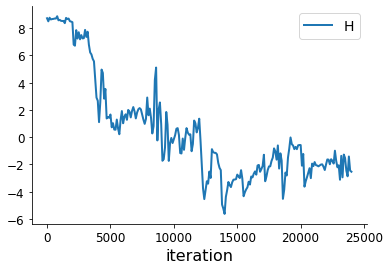

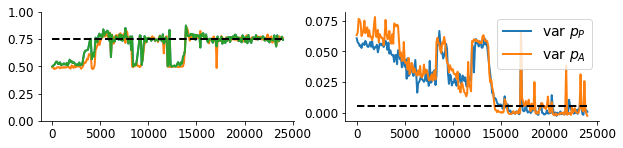

In [4]:
mu =  np.array([p, 1-p, mu_std**2, mu_std**2])
epi_df = epi_df[(epi_df['p']==p)
              & (epi_df['elemwise_fn']=="affine")
              & (epi_df['mu_std']==mu_std)
              & (epi_df['beta']==2.)
              & (epi_df['random_seed']==3)]
               #& (epi_df['c0']==1e2) 
               #& (epi_df['mu_std']==mu_std) 
               #& (epi_df['mu_len'] == 4)]


paths = sorted(epi_df['path'].unique())
for i, path in enumerate(paths):
    print(path)
    epi_df2 = epi_df[epi_df['path'] == path]
    print('mu std', epi_df2['mu_std'].iloc[0])
    print('beta', epi_df2['beta'].iloc[0])
    print('random seed', epi_df2['random_seed'].iloc[0])
    epi_df2.plot('iteration', 'H')
    plt.show()
    fig, axs = plt.subplots(1,2,figsize=(10,2))
    Rs = ['R%d' % r for r in range(1,3)]
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot(epi_df2['iteration'], 1.-(epi_df2['R2'] + mu[1]), label=r'$p_A$')
    axs[0].plot(epi_df2['iteration'], epi_df2['R1'] + mu[0], label=r'$p_P$')
    axs[0].plot([0, epi_df2['iteration'].max()], [mu[0], mu[0]], 'k--')
    axs[0].set_ylim([0,1])
    axs[1].plot(epi_df2['iteration'], epi_df2['R3'], label=r'var $p_P$')
    axs[1].plot(epi_df2['iteration'], epi_df2['R4'], label=r'var $p_A$')
    axs[1].plot([epi_df2['iteration'].min(), epi_df2['iteration'].max()], [mu_std**2, mu_std**2], 'k--')
    plt.legend()
    plt.show()

In [5]:
"""alpha, nu = 0.05, 0.25
dist, path, best_k = get_max_H_dist(model, epi_df, mu, alpha, nu, check_last_k=None)"""

'alpha, nu = 0.05, 0.25\ndist, path, best_k = get_max_H_dist(model, epi_df, mu, alpha, nu, check_last_k=None)'

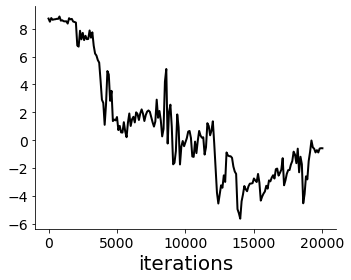

0 -
1 -
2 --
3 --


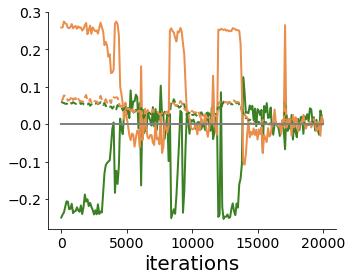

In [6]:
path = paths[0]
best_k = 10

opt_figdir = "../../written/eLifeRevision/figures/figSC6/"
cs = [c_LP, c_LA]
for path in paths:
    _epi_df = epi_df[epi_df['path'] == path]
    plot_opt(_epi_df, max_k=best_k, cs=cs, fontsize=20, figdir=opt_figdir, save=True)


In [7]:
_epi_df = epi_df[epi_df['path'] == path]
df_row = _epi_df.iloc[0]
init = df_row['init']
init_params = {"mu":init["mu"], "Sigma":init["Sigma"]}
nf = model._df_row_to_nf(df_row)
aug_lag_hps = model._df_row_to_al_hps(df_row)

dist = model._get_epi_dist(best_k, init_params, nf, mu, aug_lag_hps)

ckpt_dir data/epi/SC_Circuit_var/a2c18082e7d1e33948198182605af211/D4_C3_affine_L2_U50_rs3/9c77288aa959be8e0bb41c88f1921f85/N100_lr1.00E-03_c0=1.00E+02_gamma2.50E-01_beta2.00E+00


Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


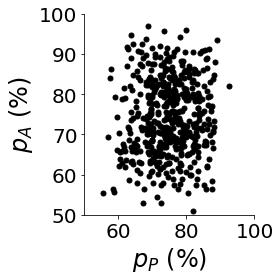

In [8]:
np.random.seed(0)
tf.random.set_seed(0)
z, log_q_z = dist.nf(500)
z = z.numpy()
log_q_z = log_q_z.numpy()
u_t, v_t = SC_sim(*unwrap(z))
u_t, v_t = u_t.numpy(), v_t.numpy()
T_x = np.mean(expit(100.*(v_t[-1,:,:,0,:] - v_t[-1,:,:,3,:])), axis=2)
pP = T_x[:,0]
pA = 1. - T_x[:,1]

fig, ax = plt.subplots(1,1,figsize=(4,4))
plt.scatter(100*(T_x[:num_plot,0]), 100.*(1-T_x[:num_plot,1]), s=25, c='k')
ax.plot([0,1], [0,1], 'k-')
plt.xlabel(r'$p_P$ (%)', fontsize=24)
plt.ylabel(r'$p_A$ (%)', fontsize=24)
plt.xlim([50, 100])
plt.ylim([50, 100])
plt.setp(ax.get_xticklabels(), fontsize=20)
plt.setp(ax.get_yticklabels(), fontsize=20)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "SC_T_x.pdf"))



In [9]:
m, b, r, pval, _ = scipy.stats.linregress(T_x[:,0], 1.-T_x[:,1])
print('pP to pA correlation', r, 'p value', pval)

pP to pA correlation 0.07918691054762415 p value 0.07689051882567029


In [10]:
val = -1.25
z0s = np.array([[0.5, -3.5, -2., val],
                [-0.5, -3.5, -2., val]])
lrs = [1e-4, 5e-4]
z_stars = []
do_plot = False
for z0, lr in zip(z0s, lrs):
    zs, log_q_zs = get_conditional_mode(dist, 3, val, z0, lr=lr, num_steps=100)
    z_stars.append(zs[-1])
    if do_plot:
        fig, axs = plt.subplots(1,2,figsize=(10,4))
        axs[0].plot(zs)
        axs[1].plot(log_q_zs)
        plt.show()
z_stars = np.array(z_stars)

hessians = dist.hessian(z_stars)
vs = []
for i in range(2):
    hess_z_i = hessians[i]
    d, v = np.linalg.eig(hess_z_i)
    min_ind = np.argmin(d)
    _v = v[:,min_ind]
    if (_v[3] > 0.):
        _v = -_v
    vs.append(_v)
    
vs = np.array(vs)
print('vs', vs)

/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/sbittner/anaconda/envs/epi/lib/python3.6/site-packages/tensorflow/python/keras/engine/base_layer.py:2273: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


vs [[-0.5405657   0.07934314 -0.01321272 -0.83744776]
 [ 0.02317544  0.02391286  0.30559027 -0.9515806 ]]


In [11]:
red = np.array([194, 31, 45, 256]) / 256.
red_clear = np.array([194, 31, 45, 192]) / 256.
purple = np.array([115, 31, 194, 256]) / 256.
purple_clear = np.array([115, 31, 194, 192]) / 256.

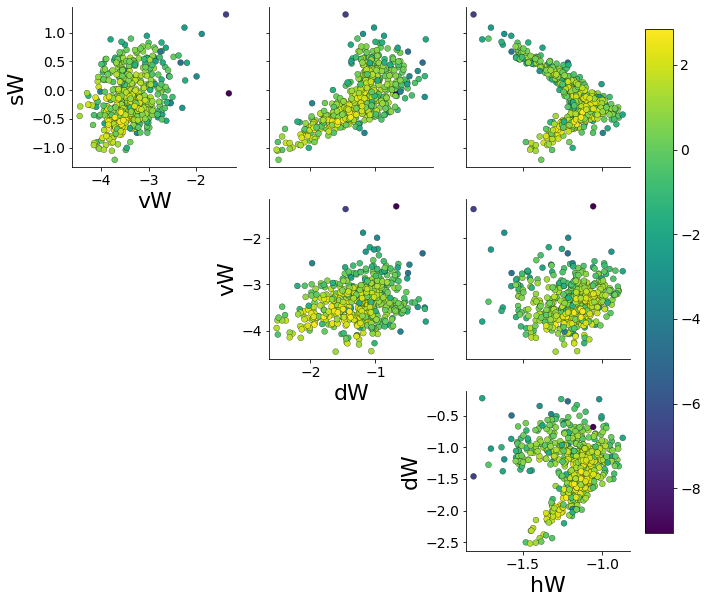

In [18]:
c_stars = [red, purple]
c_stars_clear = [red_clear, purple_clear]

alpha = 0.5
mean_z = np.mean(z, axis=0)
lim = 1.4
_lb = mean_z - lim
_ub = mean_z + lim
    
fig, axs = plt.subplots(3,3, figsize=(10,10))
"""for k, z_star in enumerate(z_stars):
    v = vs[k]
    z1 = z_star
    z2 = z_star + alpha*v
    for i in range(3):
        for j in range(i+1, 4):
            #axs[i][j-1].plot([z1[j], z2[j]], [z1[i], z2[i]], 'k-', lw=2)
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
            arrowprops=dict(headwidth=12, headlength=9, lw=2.5, color='k'))
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
             arrowprops=dict(headwidth=8, headlength=8, lw=2, color=c_stars_clear[k]))
"""            
fig, axs = pairplot(z, np.arange(4), z_labels, subplots=(fig, axs), #starred=z_stars, c_starred=c_stars,
               fontsize=22, ticksize=14, s=35,
               c=log_q_z)
plt.savefig(os.path.join(figdir, "SC_EPI_logqz.png"), dpi=600, transparent=True)

#fig = pairplot(z, np.arange(4), z_labels,
#               fontsize=26, figsize=(8,8), ticksize=16, s=35,
#               c=100.*pP, cmap=cmap_g)
#plt.savefig(os.path.join(figdir1, "SC_EPI_pP.png"), dpi=600, transparent=True)
#
#fig = pairplot(z, np.arange(4), z_labels, 
#               fontsize=26, figsize=(8,8), ticksize=16, s=35,
#               c=100.*pA, cmap=cmap_o)
#plt.savefig(os.path.join(figdir1, "SC_EPI_pA.png"), dpi=600, transparent=True)

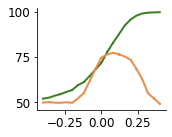

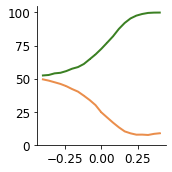

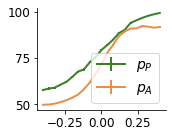

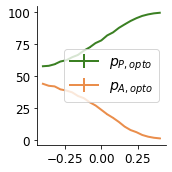

In [19]:
strength = 0.2
sc_acc_opto = SC_acc_opto(strength, 'delay')

fac_lim = 0.4
facs = np.linspace(-fac_lim, fac_lim, 21)

N_sim = 25
for k in range(2):
    z_perturb = z_stars[k][None,:] + facs[:,None]*vs[k][None,:]

    T_x_perturbs = []
    T_x_opto_perturbs = []
    for i in range(N_sim):
        print('Measuring accuracies %d/%d\r' % (i+1, N_sim), end="")
        _, v_t_perturb = SC_sim(*unwrap(z_perturb.astype(np.float32)))
        v_t_perturb = v_t_perturb.numpy()
        T_x_perturbs.append(np.mean(expit(100.*(v_t_perturb[-1,:,:,0,:] - v_t_perturb[-1,:,:,3,:])), axis=2))
        
        T_x_opto_perturbs.append(sc_acc_opto(*unwrap(z_perturb.astype(np.float32))))
        
    T_x_perturb_mean = np.mean(100.*np.array(T_x_perturbs), axis=0)
    T_x_perturb_std = np.std(100.*np.array(T_x_perturbs), axis=0) / np.sqrt(N_sim)
    pP_perturb_mean = T_x_perturb_mean[:,0]
    pP_perturb_std = T_x_perturb_std[:,0]
    pA_perturb_mean = 100.-T_x_perturb_mean[:,1]
    pA_perturb_std = T_x_perturb_std[:,1]
        
    T_x_opto_perturb_mean = np.mean(100.*np.array(T_x_opto_perturbs), axis=0)
    T_x_opto_perturb_std = np.std(100.*np.array(T_x_opto_perturbs), axis=0) / np.sqrt(N_sim)
    pP_opto_perturb_mean = T_x_opto_perturb_mean[:,2]
    pP_opto_perturb_std = T_x_opto_perturb_std[:,2]
    pA_opto_perturb_mean = 100.-T_x_opto_perturb_mean[:,3]
    pA_opto_perturb_std = T_x_opto_perturb_std[:,3]
        

    plt.figure(figsize = (2.5,2))
    plt.errorbar(facs, pP_perturb_mean, pP_perturb_std, c=c_LP)
    plt.errorbar(facs, pA_perturb_mean, pA_perturb_std, c=c_LA)
    plt.yticks([50, 75, 100])
    if k==1:
        plt.legend([r'$p_P$', r'$p_A$'], loc="lower right")
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "SC_perturb_acc_%d.png" % (k+1)), transparent=True)
    plt.show()
    
    plt.figure(figsize = (2.5, 2.5))
    plt.errorbar(facs, pP_opto_perturb_mean, pP_opto_perturb_std, c=c_LP)
    plt.errorbar(facs, pA_opto_perturb_mean, pA_opto_perturb_std, c=c_LA)
    plt.yticks([0, 25, 50, 75, 100])
    if k==1:
        plt.legend([r'$p_{P,opto}$', r'$p_{A,opto}$'], loc="center right")
    plt.tight_layout()
    plt.savefig(os.path.join(figdir, "SC_perturb_acc_opto_%d.png" % (k+1)), transparent=True)
    plt.show()
    


In [20]:
W_stars = z_to_W(z_stars)
eigs_stars = np.array([get_schur_eigs(W_stars[i]) for i in range(z_stars.shape[0])])

eigs_perturbs = []
for i in range(2):
    z_perturb = z_stars[i][None,:] + alpha*vs[i][None,:] 
    W_perturb = z_to_W(z_perturb)
    eigs_perturbs.append([get_schur_eigs(W_perturb[i]) for i in range(z_perturb.shape[0])])
eigs_perturbs = np.array(eigs_perturbs)[:,0,:]


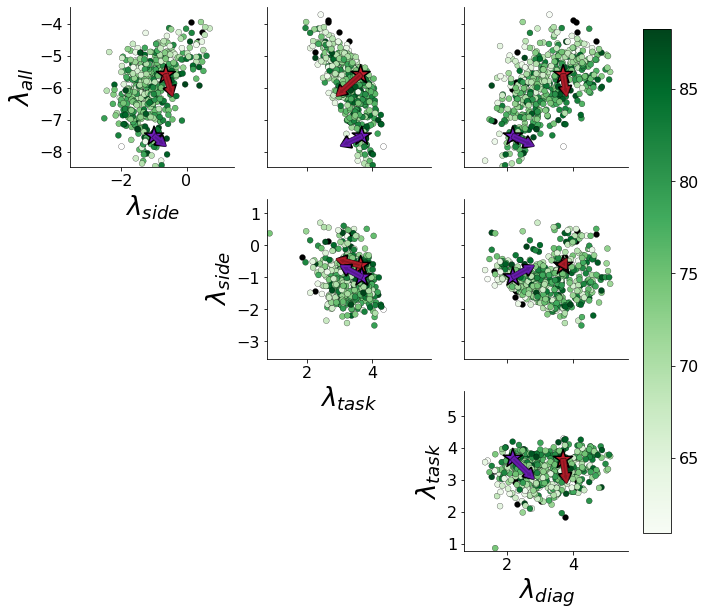

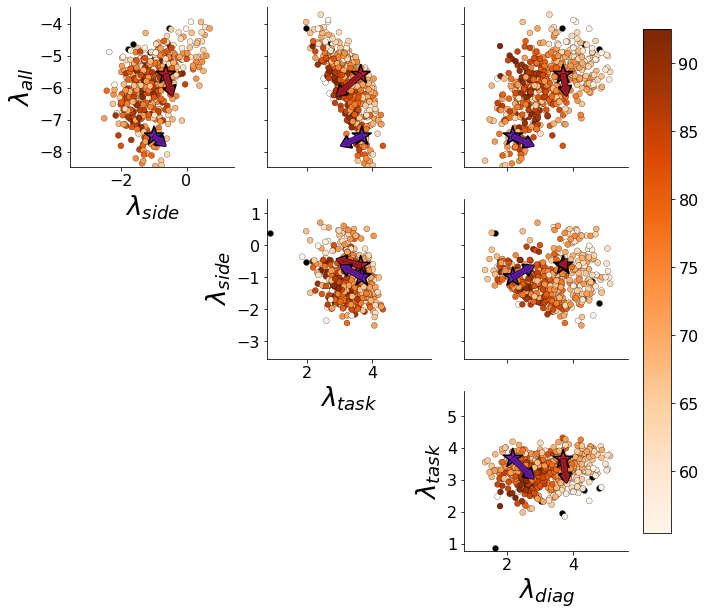

In [21]:
ylabels = [r'$p_P$ (%)', r'$p_A$ (%)']

W = z_to_W(z)
eigs = np.array([get_schur_eigs(W[i]) for i in range(z.shape[0])])
means = np.mean(eigs, 0)
_lb = means - 2.5
_ub = means + 2.5

eig_names = ['all', 'side', 'task', 'diag']
eig_labels = [r'$\lambda_{%s}$' % eig_name for eig_name in eig_names]

fig, axs = plt.subplots(3,3, figsize=(10,10))
for k, (eigs_star, eigs_perturb) in enumerate(zip(eigs_stars, eigs_perturbs)):
    v = vs[k]
    z1 = eigs_star
    z2 = eigs_perturb
    for i in range(3):
        for j in range(i+1, 4):
            #axs[i][j-1].plot([z1[j], z2[j]], [z1[i], z2[i]], 'k-', lw=2)
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
            arrowprops=dict(headwidth=12, headlength=9, lw=2.5, color='k'))
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
            arrowprops=dict(headwidth=8, headlength=8, lw=2, color=c_stars_clear[k]))
            
fig, axs = pairplot(eigs, np.arange(4), eig_labels, outlier_stds=2, subplots=(fig, axs),
               starred=eigs_stars, c_starred = c_stars, lb=_lb, ub=_ub,
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=100*pP, cmap=cmap_g)
plt.savefig(os.path.join(figdir4, "SC_EPI_pP.png"))
plt.show()

fig, axs = plt.subplots(3,3, figsize=(10,10))
for k, (eigs_star, eigs_perturb) in enumerate(zip(eigs_stars, eigs_perturbs)):
    v = vs[k]
    z1 = eigs_star
    z2 = eigs_perturb
    for i in range(3):
        for j in range(i+1, 4):
            #axs[i][j-1].plot([z1[j], z2[j]], [z1[i], z2[i]], 'k-', lw=2)
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
            arrowprops=dict(headwidth=12, headlength=9, lw=2.5, color='k'))
            axs[i][j-1].annotate("", xy=[z2[j], z2[i]], xytext=[z1[j], z1[i]], 
            arrowprops=dict(headwidth=8, headlength=8, lw=1.5, color=c_stars_clear[k]))
            
fig, axs = pairplot(eigs, np.arange(4), eig_labels, outlier_stds=2, subplots=(fig, axs),
               starred=eigs_stars, c_starred = c_stars, lb=_lb, ub=_ub,
               fontsize=26, figsize=(10,10), ticksize=16, s=35, c=100*pA, cmap=cmap_o)
plt.savefig(os.path.join(figdir4, "SC_EPI_pA.png"))
plt.show()

[-0.4  0.   0.4]
53.1, 52.0


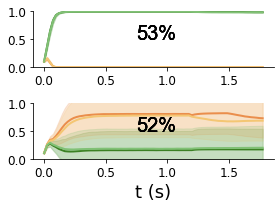

76.6, 72.9


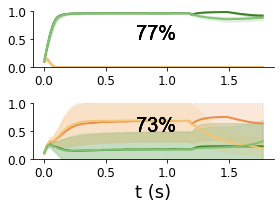

100.0, 49.0


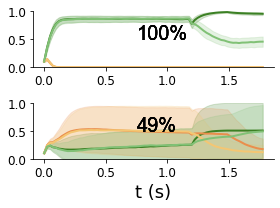

60.8, 52.4


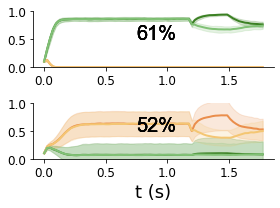

75.7, 73.2


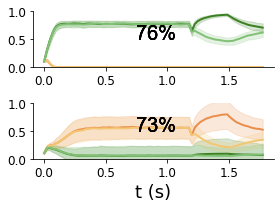

100.0, 92.0


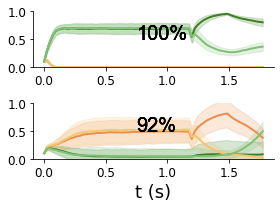

In [23]:
from epi.SC_Circuit_4 import plot_SC_responses

fac_lim = 0.4
facs = np.linspace(-fac_lim, fac_lim, 3)
print(facs)
for i in range(2):
    z_perturb = z_stars[i][None,:] + facs[:,None]*vs[i][None,:]
    _, v_t_perturb = SC_sim(*unwrap(z_perturb.astype(np.float32)))
    v_t_perturb = v_t_perturb.numpy()
    #fname = os.path.join(figdir, "z%d_" % (i+1))
    #plot_SC_responses(v_t_perturb, fname)
    fname = os.path.join(figdir2, "z%d_" % (i+1))
    plot_SC_responses(v_t_perturb, fname, figsize=(4,3))

In [18]:
ylabels = [r'$p_P$ (%)', r'$p_A$ (%)']

def plot_2corrs(x, xlabel, y1, y2, ylabels, ylims=None, alignment='h', 
                 s=10, num_plot=None, c=None, fontsize=20):
    x_mean, x_std = np.mean(x) ,np.std(x)
    ys = [y1, y2]
    lin_models = [scipy.stats.linregress(x, y) for y in ys]
    if c is None:
        c = 'k'
    xticksize = fontsize-6
    yticksize = fontsize-4
    titlesize = fontsize-4
    if alignment == 'h':
        fig, axs = plt.subplots(1,2,figsize=(10,4))
    elif alignment == 'v':
        fig, axs = plt.subplots(2,1,figsize=(4,8))
    else:
        return None
    
    x = x[:num_plot]
    y1 = y1[:num_plot]
    y2 = y2[:num_plot]
    
    axs[0].scatter(x, y1, s=s, c=c)
    axs[0].set_xlabel(xlabel, fontsize=fontsize)
    axs[0].set_ylabel(ylabels[0], fontsize=fontsize)
    plt.setp(axs[0].get_xticklabels(), fontsize=xticksize)
    plt.setp(axs[0].get_yticklabels(), fontsize=yticksize)
    axs[1].scatter(x, y2, s=s, c=c)
    axs[1].set_xlabel(xlabel, fontsize=fontsize)
    axs[1].set_ylabel(ylabels[1], fontsize=fontsize)
    plt.setp(axs[1].get_xticklabels(), fontsize=xticksize)
    plt.setp(axs[1].get_yticklabels(), fontsize=yticksize)
    
    for i, y in enumerate(ys):
        x1, x2 = x_mean-5*x_std, x_mean+5*x_std
        axs[i].set_xlim([x1, x2])
        m, b, r, pval, _ = lin_models[i]
        axs[i].plot([x1, x2], [b + m*x1, b+m*x2], 'k--')
        if pval < 0.05:
            pval_str = ""
        else:
            pval_str = "(n.s.)"
        metric_str = (r"$\beta$=%.1E, r=%.2f," "\n" "p=%.1E %s") % (m,r,pval,pval_str)
        axs[i].set_title(metric_str, fontsize=titlesize)
        if ylims is not None:
            axs[i].set_ylim(ylims)
        
    return None



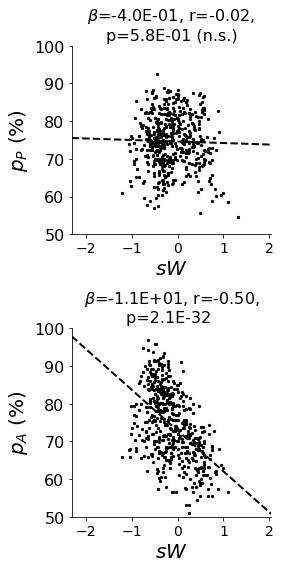

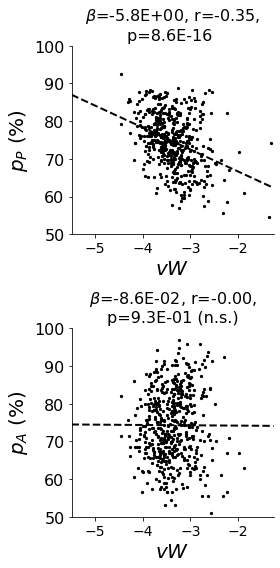

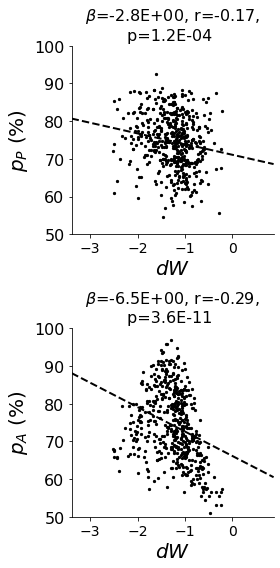

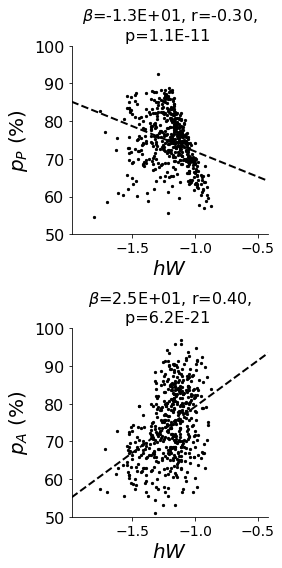

In [19]:
sW = z[:,0]
vW = z[:,1]
dW = z[:,2]
hW = z[:,3]

xs = [sW, vW, dW, hW]
xlabels = [r'$sW$', r'$vW$', r'$dW$', r'$hW$']

for i, (x, xlabel) in enumerate(zip(xs, xlabels)):
    plot_2corrs(x, xlabel, 100*pP, 100*pA, ylabels, ylims = [50, 100],
                 alignment='v', s=5, num_plot=500)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir1, "%s_corr.pdf" % xlabel), transparent=True)
    plt.show()

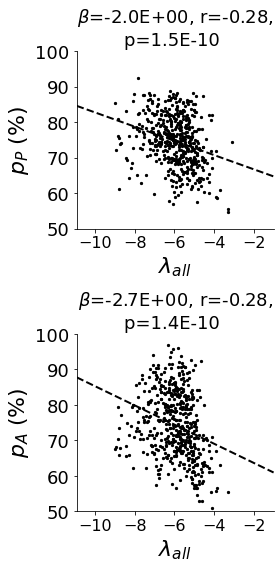

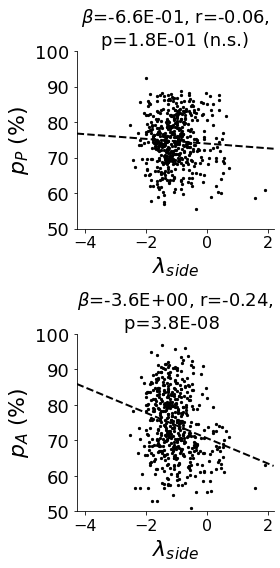

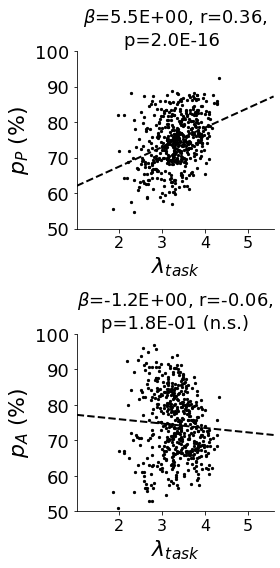

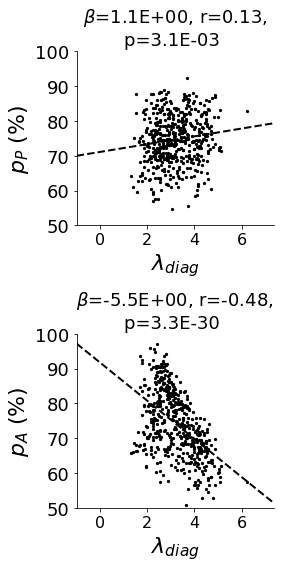

In [20]:
for i in range(4):
    plot_2corrs(eigs[:,i], eig_labels[i], 
                100*pP, 100*pA, ylabels, ylims=[50, 100],
                alignment='v', s=5, num_plot=500, fontsize=22)
    plt.tight_layout()
    plt.savefig(os.path.join(figdir3, "lambda_%s.pdf" % eig_names[i]), transparent=True)

str 0.2
(500,)
76.6, 24.4


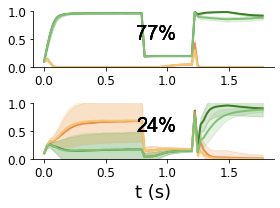

77.2, 26.0


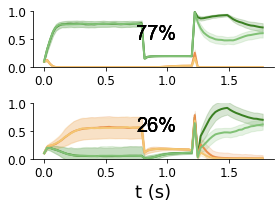

In [21]:
strength = 0.2
sc_sim_opto = SC_sim_opto(strength, 'delay')
_, v_t_stars = sc_sim_opto(*unwrap(z_stars))
v_t_stars = v_t_stars.numpy()[:,:,2:,:,:]
print(x.shape)

fname = os.path.join(figdir5, "opt_")
plot_SC_responses(v_t_stars, fname, figsize=(4,3))

In [22]:
def plot_corr(x, xlabel, y, ylabel, ylim=None, 
                 s=10, num_plot=None, c=None, fontsize=20):
    x_mean, x_std = np.mean(x) ,np.std(x)
    lin_model = scipy.stats.linregress(x, y)
    if c is None:
        c = 'k'
    xticksize = fontsize-6
    yticksize = fontsize-4
    titlesize = fontsize-4
    fig, ax = plt.subplots(1,1,figsize=(4,4))
    x = x[:num_plot]
    y = y[:num_plot]
    
    ax.scatter(x, y, s=s, c=c)
    ax.set_xlabel(xlabel, fontsize=fontsize)
    ax.set_ylabel(ylabel, fontsize=fontsize)
    plt.setp(ax.get_xticklabels(), fontsize=xticksize)
    plt.setp(ax.get_yticklabels(), fontsize=yticksize)
    
    x1, x2 = x_mean-3.5*x_std, x_mean+3.5*x_std
    ax.set_xlim([x1, x2])
    m, b, r, pval, _ = lin_model
    ax.plot([x1, x2], [b + m*x1, b+m*x2], 'k--')
    if pval < 0.05:
        pval_str = ""
    else:
        pval_str = "(n.s.)"
    metric_str = (r"$\beta$=%.1E, r=%.2f," "\n" "p=%.1E %s") % (m,r,pval,pval_str)
    ax.set_title(metric_str, fontsize=titlesize)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    return fig, ax

In [23]:
N_opto_test = 100
strength = 0.2
sc_acc_diff = SC_acc_diff(strength, 'delay')
diffs = sc_acc_diff(*unwrap(z[:N_opto_test,:])).numpy()
diffs[:,1] = -diffs[:,1]

0 0.6589054210404985 0.5114861379086257
1 36.992377509120814 9.060369857074151e-60
two-tailed


Ttest_relResult(statistic=-36.7726378972512, pvalue=1.5707180266575138e-59)

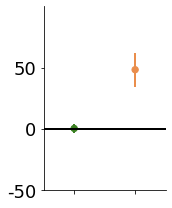

In [24]:
mean_diff = np.mean(100.*diffs, axis=0)
std_diff = np.std(100.*diffs, axis=0)
fig, ax = plt.subplots(1,1,figsize=(2.5,3))
_cs = [c_LP, c_LA]
plt.scatter([0,1], mean_diff, color=_cs, s=40)
for i in range(2):
    plt.plot([i,i], [mean_diff[i]-std_diff[i], mean_diff[i]+std_diff[i]], '-', c=_cs[i])
plt.ylim([-5, 100])
plt.xlim([-.5, 1.5])
plt.plot([-1, 2], [0, 0], 'k-')
ax.set_xticks([0,1])
ax.set_xticklabels(['', ''], fontsize=18)
ax.set_yticks([-50, 0,50])
ax.set_yticklabels([-50, 0,50], fontsize=18)

plt.tight_layout()
plt.savefig(os.path.join(figdir, "delay_error.pdf"), transparent=True)
for i in range(2):
    t, p = scipy.stats.ttest_1samp(diffs[:,i], 0.)
    print(i,t,p)
    
print('two-tailed')
scipy.stats.ttest_rel(diffs[:,0], diffs[:,1])

In [25]:
plot_corr(100.*acc_opto[:,0], r'$p_P$', 100*(1.-acc_opto[:,3]), r'$p_{A,opto}$',
                    s=5, num_plot=500, fontsize=22)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "AntiError_P.pdf"), transparent=True)

plot_corr(100.*(1.-acc_opto[:,1]), r'$p_A$', 100*(1.-acc_opto[:,3]), r'$p_{A,opto}$',
                    s=5, num_plot=500, fontsize=22)
plt.tight_layout()
plt.savefig(os.path.join(figdir, "AntiError_A.pdf"), transparent=True)

NameError: name 'acc_opto' is not defined

In [26]:
y_labels = ['Pro error (%)', r'Anti error (%)']
tasks = ['P', 'A']
ylims = [[-7.5, 7.5], [0, 75]]
for j in range(2):
    ylim = ylims[j]
    for i, eig_name in enumerate(eig_names):
        if i==0:
            y_label = y_labels[j]
        else:
            y_label = ""
        fig, ax = plot_corr(eigs[:,i], r'$\lambda_{%s}$' % eig_name, 
                    100*diffs[:,j], y_label, ylim=ylim,
                    s=5, num_plot=500, fontsize=26)
        if j==0:
            ax.set_yticks([-5, 0, 5])
        plt.tight_layout()
        plt.savefig(os.path.join(figdir5, "lambda_opto_%s_%s.pdf" % (eig_name, tasks[j])), 
                    transparent=True)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 500 and the array at index 1 has size 100

In [27]:
ylabels = [r'$p_P-p_{P,opto}$ (%)', r'$p_A-p_{A,opto}$ (%)']
plot_2corrs(pP, r'$p_P$', 100*diffs[:,0], 100*diffs[:,1], ylabels, 
             alignment='v', s=5, num_plot=500, fontsize=22)
plt.tight_layout()
#plt.savefig(os.path.join(figdir, "pP_opto.pdf"))

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 500 and the array at index 1 has size 100

In [28]:
periods = ['delay', 'choice', 'total']
strengths = np.linspace(0., 1., 21)
diffs = []
approx_num = 100

for period in periods:
    _diffs = []
    for strength in strengths:
        print(period, strength)
        sc_acc_diff = SC_acc_diff(strength, period)
        _diff = sc_acc_diff(*unwrap(z[:approx_num])).numpy()
        _diff[:,1] = -_diff[:,1]
        _diffs.append(_diff)
    diffs.append(np.array(_diffs))

delay 0.0
delay 0.05
delay 0.1
delay 0.15000000000000002
delay 0.2
delay 0.25
delay 0.30000000000000004
delay 0.35000000000000003
delay 0.4
delay 0.45
delay 0.5
delay 0.55
delay 0.6000000000000001
delay 0.65
delay 0.7000000000000001
delay 0.75
delay 0.8
delay 0.8500000000000001
delay 0.9
delay 0.9500000000000001
delay 1.0
choice 0.0
choice 0.05
choice 0.1
choice 0.15000000000000002
choice 0.2
choice 0.25
choice 0.30000000000000004
choice 0.35000000000000003
choice 0.4
choice 0.45
choice 0.5
choice 0.55
choice 0.6000000000000001
choice 0.65
choice 0.7000000000000001
choice 0.75
choice 0.8
choice 0.8500000000000001
choice 0.9
choice 0.9500000000000001
choice 1.0
total 0.0
total 0.05
total 0.1
total 0.15000000000000002
total 0.2
total 0.25
total 0.30000000000000004
total 0.35000000000000003
total 0.4
total 0.45
total 0.5
total 0.55
total 0.6000000000000001
total 0.65
total 0.7000000000000001
total 0.75
total 0.8
total 0.8500000000000001
total 0.9
total 0.9500000000000001
total 1.0


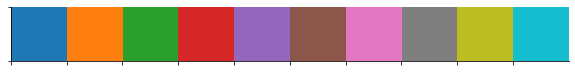

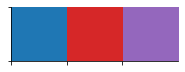

In [30]:
import seaborn as sns
pal = sns.color_palette()
sns.palplot(pal)
opto_colors = [pal[i] for i in [0, 3, 4]]
sns.palplot(opto_colors)

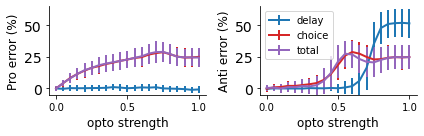

In [35]:
fig, axs = plt.subplots(1,2,figsize=(6,2))
for i, period in enumerate(periods):
    diff_mean = np.mean(100.*diffs[i], axis=1)
    diff_std = np.std(100.*diffs[i], axis=1)
    for j in range(2):
        axs[j].errorbar(1.-strengths, diff_mean[:,j], diff_std[:,j],
                        c=opto_colors[i], label=period)

ylabels = ['Pro error (%)', 'Anti error (%)']
fontsize = 12
ticksize = fontsize-2
for j in range(2):
    axs[j].set_xlabel('opto strength', fontsize=fontsize)
    axs[j].set_ylabel(ylabels[j], fontsize=fontsize)
    axs[j].set_ylim([-5, 65])
    plt.setp(axs[j].get_xticklabels(), fontsize=ticksize)
    plt.setp(axs[j].get_yticklabels(), fontsize=(ticksize+4))
axs[1].legend(fontsize=ticksize)
plt.tight_layout()
plt.savefig(os.path.join(figdir5, "strength_sweeps.pdf"))